## E20. 다른 시계열 데이터에서 이상치를 찾아보자

### Step 1. 데이터 구하기

In [1]:
import requests
import os

csv_file = os.getenv('HOME') + '/aiffel/anomaly_detection/nasdaq/NQ.csv'

import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


### Step 2. 기본 통계분석으로 이상치 찾기

In [2]:
df.loc[:,'Date'] = pd.to_datetime(df.Date)

df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [3]:
print("삭제 전 데이터 길이(일자수):", len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):", len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6167
삭제 후 데이터 길이(일자수): 5095


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

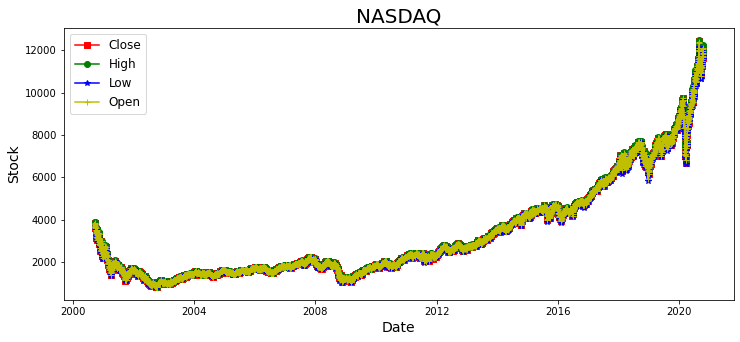

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12, 5)

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

- 눈으로 보았을 때 특이값은 없어보임

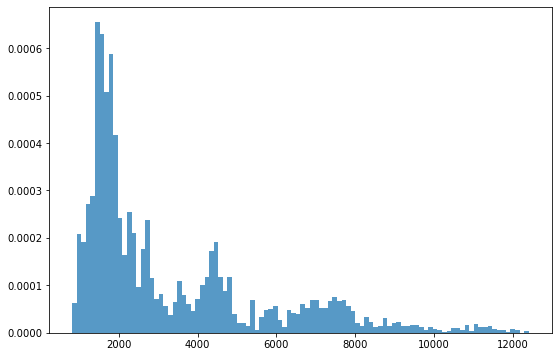

In [5]:
fig, ax = plt.subplots(figsize = (9, 6))
_= plt.hist(df.Close, 100, density=True, alpha = 0.75)

In [6]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


- 정규분포와 거리가 멀다

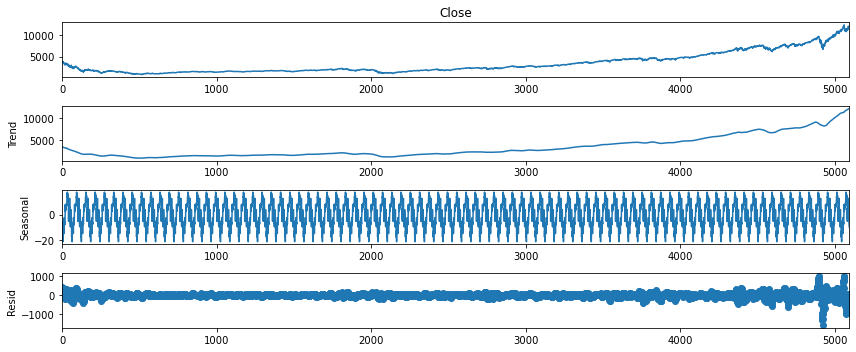

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided = True,
                           period=60, extrapolate_trend='freq')
result.plot()
plt.show()

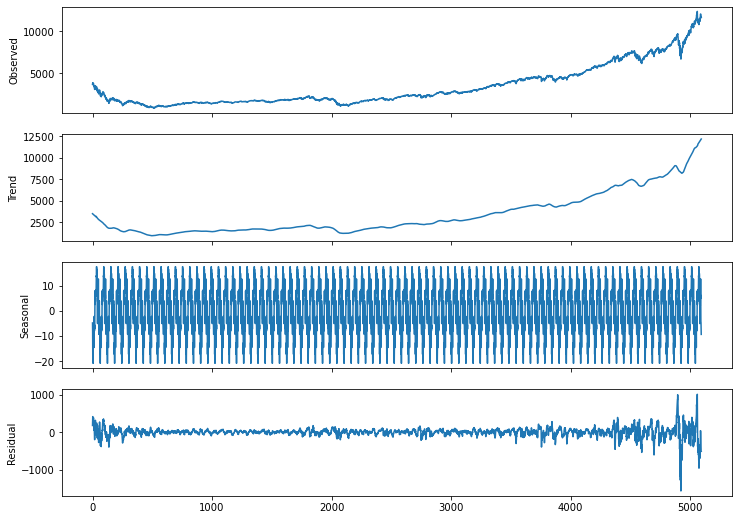

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

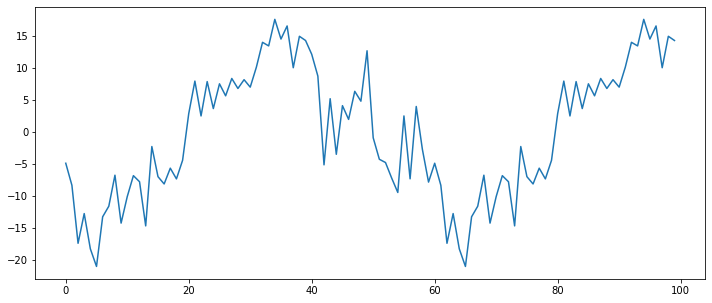

In [9]:
result.seasonal[:100].plot()

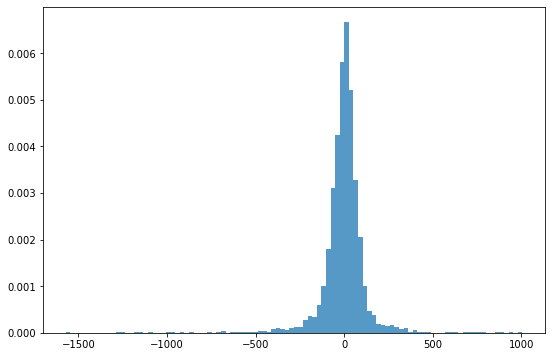

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [11]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.9988643281958943 0.3178604186032079


- p값이 0.05이상이므로 정규분포 따름

In [12]:
mu, std = result.resid.mean(), result.resid.std()
print("평균: ", mu, "표준편차: ", std)

print("이상치 갯수: ", len(result.resid[(result.resid > mu + 3 * std) | (result.resid <mu-3*std)]))

평균:  -1.7372247811800174 표준편차:  124.14281994665608
이상치 갯수:  91


In [13]:
df.Date[result.resid[(result.resid > mu +3*std) | (result.resid < mu - 3 * std)].index]

2      2000-09-20
8      2000-09-28
73     2001-01-02
136    2001-04-03
137    2001-04-04
          ...    
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
5094   2020-10-20
Name: Date, Length: 91, dtype: datetime64[ns]

- 닷컴 버블로 인한 급락시장일때와 최근 나스닥의 사상최고가 근처의 급등락 구간이 잡힌 것으로 추정되며 outlier가 아닌, novelty로 추정됨
- 데이터에 이상이 있는 것은 아니며 정상적인 시장 데이타이므로 그대로 두어야 할 것 같다.

### Step 3. Unsupervised Clustering으로 이상치 찾기

In [14]:
def my_decompose(df, features, freq = 50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    for f in features:
        result = seasonal_decompose(df[f],
                                   model='additive', period = freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

tdf, sdf, rdf = my_decompose(df, features=['Open', 'High', 'Low', 'Close', 'Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5095.000000,5095.000000,5095.000000,5095.000000,5095.000000
mean,3325.907049,3357.302099,3293.785671,3327.771059,287860.682497
std,2393.374960,2415.079150,2372.312929,2397.251426,109578.780934
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.281250,1597.585000,1571.072500,1584.219401,220557.230000
50%,2264.057500,2291.320000,2232.157500,2264.745801,268863.030000
75%,4433.847500,4464.360000,4400.128750,4435.147500,319644.035000
max,12058.542508,12211.432308,11890.657546,12062.370185,776809.340000


In [15]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5095.000000,5095.000000,5095.000000,5095.000000,5095.000000
mean,-1.454283,-1.429995,-1.346435,-1.379786,159.598052
std,112.853008,102.399994,117.045523,110.603707,110728.639267
min,-1280.274119,-1494.348694,-1226.692253,-1389.885307,-602979.151226
25%,-38.048352,-35.122563,-38.273425,-37.529027,-53357.046608
50%,3.464276,3.345588,4.081152,2.988941,-549.819472
75%,40.327473,37.514393,41.934675,40.920737,51629.952133
max,996.861502,933.601556,941.458349,996.255217,810717.596958


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.45428266  -1.4299945   -1.34643465  -1.37978605 159.5980523 ]


array([[ 0.94384715,  0.84358131,  0.81322346,  0.59885703,  0.08320919],
       [ 0.48764736,  1.27983292,  1.38152607,  2.08512207,  0.10452665],
       [ 1.89730477,  2.01151387,  2.03795522,  2.72428864, -0.08886786],
       ...,
       [-1.10087683, -1.41434904, -0.50248845, -1.98119535, -0.37711411],
       [-1.90943614, -2.27677765, -2.37035191, -3.5066876 ,  0.56369281],
       [-3.15366786, -4.03682879, -2.47475959, -3.59069502,  0.71939814]])

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_)

[1 1 1 ... 0 0 0]


In [18]:
import numpy as np

lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
print(lbl)
print(cnt)

[0 1]
[1028 4067]


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_, return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:371',
 'group:1-count:424',
 'group:2-count:31',
 'group:3-count:291',
 'group:4-count:688',
 'group:5-count:20',
 'group:6-count:516',
 'group:7-count:13',
 'group:8-count:403',
 'group:9-count:66',
 'group:10-count:34',
 'group:11-count:104',
 'group:12-count:105',
 'group:13-count:1021',
 'group:14-count:1008']

- 70개이하의 그룹을 특이 그룹으로 판단

In [20]:
df[(kmeans.labels_==2) | (kmeans.labels_==5) | (kmeans.labels_==7) | (kmeans.labels_==9) | (kmeans.labels_==10)]

,Date,Open,High,Low,Close,Adj Close,Volume
137,2001-04-04,1407.500000,1451.000000,1361.000000,1379.500000,1379.500000,141811.0
845,2004-01-15,1532.000000,1548.500000,1516.000000,1537.500000,1537.500000,487414.0
846,2004-01-16,1536.500000,1556.000000,1535.500000,1553.000000,1553.000000,487414.0
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1742,2007-07-26,2026.500000,2039.500000,1969.250000,2000.500000,2000.500000,808824.0
...,...,...,...,...,...,...,...
5084,2020-10-06,11473.000000,11524.500000,11197.500000,11273.799805,11273.799805,612278.0
5085,2020-10-07,11220.500000,11506.500000,11208.000000,11470.000000,11470.000000,443046.0
5086,2020-10-08,11473.200195,11578.799805,11469.799805,11539.000000,11539.000000,403379.0
5089,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0


In [21]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5095.000000,5095.000000,5095.000000,5095.000000,5095.000000,5.095000e+03
mean,3324.444159,3355.865409,3292.428055,3326.382265,3326.382265,2.880397e+05
std,2393.123608,2414.305013,2372.716689,2396.949235,2396.949235,1.594697e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.875000,1608.375000,1576.500000,1593.000000,1593.000000,1.907070e+05
50%,2230.000000,2258.500000,2211.000000,2230.500000,2230.500000,2.656760e+05
75%,4445.375000,4464.750000,4418.625000,4449.125000,4449.125000,3.560010e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [22]:
df.iloc[845:855]

,Date,Open,High,Low,Close,Adj Close,Volume
845,2004-01-15,1532.0,1548.5,1516.0,1537.5,1537.5,487414.0
846,2004-01-16,1536.5,1556.0,1535.5,1553.0,1553.0,487414.0
847,2004-01-19,1552.5,1558.5,1551.5,1553.0,1553.0,234942.0
848,2004-01-20,1552.5,1563.0,1542.5,1553.0,1553.0,281566.0
849,2004-01-21,1552.0,1557.5,1530.5,1547.0,1547.0,385113.0
850,2004-01-22,1550.0,1557.5,1532.5,1534.5,1534.5,316770.0
851,2004-01-23,1527.0,1549.5,1521.0,1533.0,1533.0,312443.0
852,2004-01-26,1530.5,1556.0,1523.5,1554.5,1554.5,261568.0
853,2004-01-27,1554.0,1557.0,1519.5,1520.0,1520.0,344904.0
854,2004-01-28,1519.5,1532.5,1489.0,1494.0,1494.0,369978.0


In [23]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

,Open,High,Low,Close,Volume
0,-0.162053,-0.179096,-0.355487,-0.333840,1.357298
1,0.907354,0.934408,0.993645,0.976686,-0.547881
2,-4.175307,-4.596273,-4.152288,-4.315482,0.462424
3,0.076214,0.073297,0.144922,0.138988,-1.907189
4,0.444657,0.479079,0.393641,0.403715,0.440727
5,6.041974,6.096371,6.092206,6.011166,-0.221767
6,-0.476780,-0.512663,-0.394322,-0.423148,-0.563859
7,-8.250059,-7.523266,-8.303433,-7.388892,-1.793801
8,-0.912747,-0.937544,-0.904032,-0.886644,0.483434
9,-1.171743,-1.286703,-1.818052,-1.747289,3.126169


- 가장 특이한 그룹으로 7번 그룹을 들 수 있겠다.

In [24]:
df[(kmeans.labels_==7)]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.000000,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


- 코로나19로 인한 급락시장의 날짜들과 나스닥 사상 최고가 도달 이후 급락 날짜가 많이 포함되어 있는 것을 확인할 수 있다.
- 정상적인 시장 흐름에 따른 데이터이므로 novelties로 간주하고 그대로 두어야 할 것 같다.

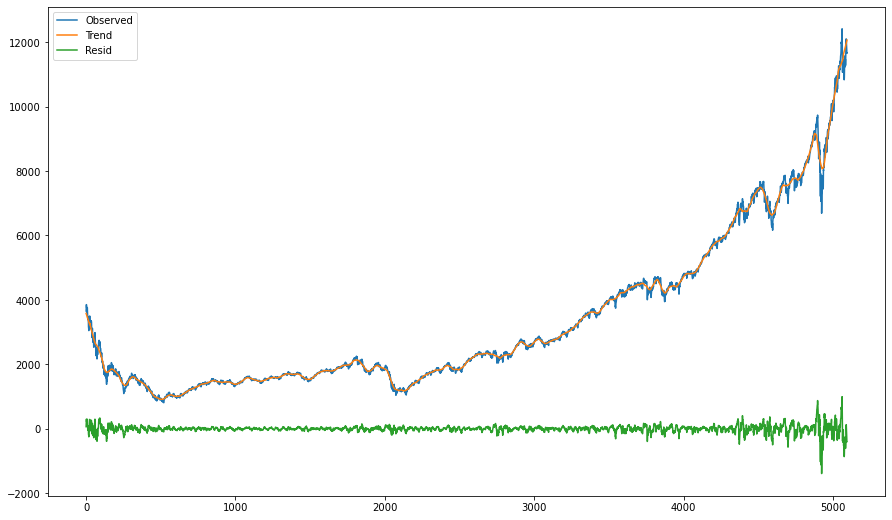

In [25]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
df.Close.plot(ax = ax, label = 'Observed', legend = True)
tdf.Close.plot(ax = ax, label = 'Trend', legend = True)
rdf.Close.plot(ax = ax, label = 'Resid', legend = True)
plt.show()

In [26]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [27]:
print(clustering.labels_)

[ 0  0  0 ... -1 -1 -1]


In [28]:
lbl, cnt = np.unique(clustering.labels_, return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:198',
 'group:0-count:4839',
 'group:1-count:3',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:3',
 'group:22-count:2']

In [43]:
df[(clustering.labels_==1)|(clustering.labels_>=3)] 

,Date,Open,High,Low,Close,Adj Close,Volume
41,2000-11-14,2826.000000,3068.000000,2825.000000,3057.500000,3057.500000,72323.0
55,2000-12-05,2563.000000,2857.000000,2530.000000,2840.000000,2840.000000,93557.0
65,2000-12-19,2609.500000,2686.000000,2393.000000,2410.000000,2410.000000,83019.0
76,2001-01-05,2485.000000,2551.000000,2273.500000,2293.500000,2293.500000,94688.0
137,2001-04-04,1407.500000,1451.000000,1361.000000,1379.500000,1379.500000,141811.0
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1816,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0
3542,2014-10-13,3848.500000,3885.750000,3792.500000,3798.500000,3798.500000,636045.0
3543,2014-10-14,3798.000000,3852.750000,3793.000000,3811.750000,3811.750000,602322.0
4396,2018-03-14,7039.500000,7098.000000,7012.250000,7033.500000,7033.500000,117327.0


- 역시 닷컴 버블 붕괴 시점과 2007년말 금융위기 최근 코로나19로 인한 급등락, 나스닥 최고가 근처에서의 급등락이 반영된 것으로 보입니다.
- 이 값들은 특이치로 간주하고 그대로 반영하는 것이 좋을 것 같습니다.

### 4. LSTM 오토인코더로 이상치 찾기

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
tf.random.set_seed(777)
np.random.seed(777)

In [32]:
from sklearn.preprocessing import StandardScaler

window_size = 10
batch_size = 32
features = ['Open', 'High', 'Low', 'Close', 'Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE, features].values)
scaled = scaler.transform(df[features].values)

In [33]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride = 1,
    sampling_rate = 1,
    batch_size= batch_size,
    shuffle= False,
    start_index = 0,
    end_index = None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets= scaled,
    length= window_size,
    stride= 1,
    sampling_rate = 1,
    batch_size= batch_size,
    shuffle= False,
    start_index = TRAIN_SIZE,
    end_index = None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [34]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences = True,
        input_shape = (window_size, n_features)),
    LSTM(16, activation='relu', return_sequences = False),
    
    RepeatVector(window_size),
    
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [35]:
import os

checkpoint_path = os.getenv('HOME') +'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mae', optimizer='adam', metrics=["mae"])

In [36]:
hist = model.fit(train_gen,
                validation_data = valid_gen,
                steps_per_epoch = len(train_gen),
                validation_steps = len(valid_gen),
                epochs = 50,
                callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.3280 - mae: 1.3280
Epoch 00001: val_loss improved from inf to 1.61664, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 1.3280 - mae: 1.3280 - val_loss: 1.6166 - val_mae: 1.6166
Epoch 2/50
158/159 [============================>.] - ETA: 0s - loss: 0.6584 - mae: 0.6584
Epoch 00002: val_loss improved from 1.61664 to 0.86815, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 4s 27ms/step - loss: 0.6690 - mae: 0.6690 - val_loss: 0.8681 - val_mae: 0.8681
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.4316 - mae: 0.4316
Epoch 00003: val_loss improved from 0.86815 to 0.62257, saving model to /home/aiffel/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 0.4316 - mae: 0.4316 - val_loss: 

In [37]:
model.load_weights(checkpoint_path)

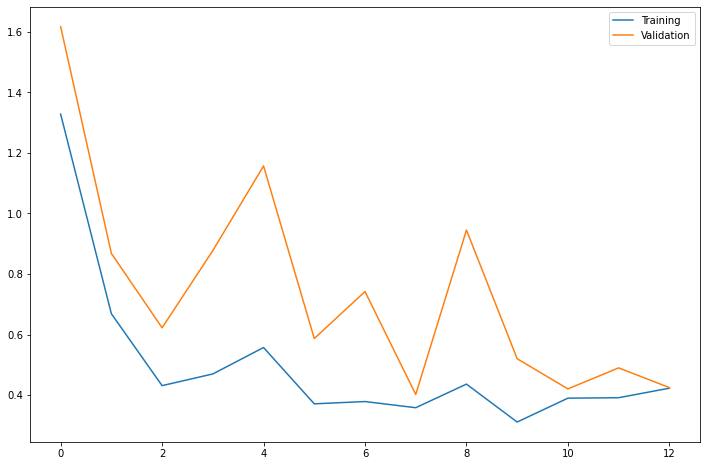

In [38]:
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.history['loss'], label = 'Training')
plt.plot(hist.history['val_loss'], label = 'Validation')
plt.legend()

- loss가 줄어들며 정상적으로 학습되었음을 확인

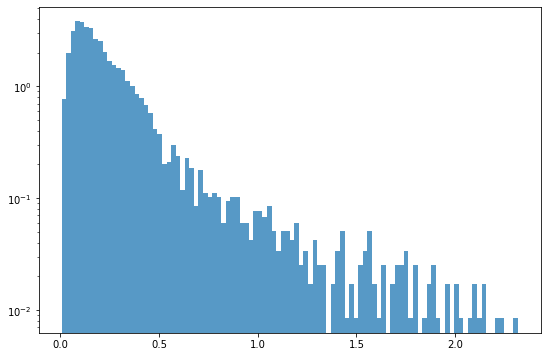

In [39]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

fig, ax = plt.subplots(figsize = (9, 6))
_= plt.hist(mae_loss, 100, density=True, alpha = 0.75, log=True)

In [40]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop = True)
test_df['Loss'] = mae_loss

threshold = 1.3
test_df.loc[test_df.Loss > threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4360,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.388492
4396,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.304977
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.788261
4543,2018-10-26,6882.000000,6986.500000,6734.250000,6893.250000,6893.250000,1069548.0,1.425906
4560,2018-11-20,6668.500000,6670.000000,6449.500000,6532.500000,6532.500000,910469.0,1.310816
...,...,...,...,...,...,...,...,...
5080,2020-10-14,12079.799805,12178.000000,11901.799805,11974.200195,11974.200195,597198.0,1.722866
5081,2020-10-15,11950.000000,11983.200195,11736.500000,11874.000000,11874.000000,595926.0,1.626445
5082,2020-10-16,11891.000000,12022.000000,11792.000000,11798.000000,11798.000000,527026.0,1.565573
5083,2020-10-19,11816.799805,11950.500000,11591.200195,11650.200195,11650.200195,623203.0,1.598701


- 최근의 코로나19로 인한 급락시장과, 나스닥 사상최고가 이후의 급락시장 날짜를 찾아냄

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


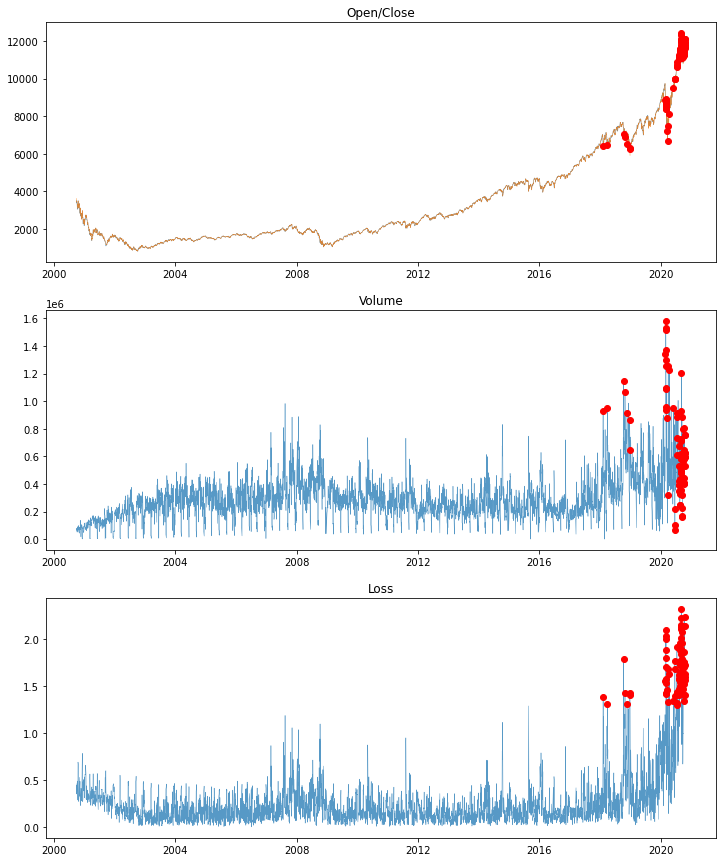

In [41]:
fig = plt.figure(figsize=(12, 15))

#가격
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth = 0.5, alpha = 0.75, label = 'Close')
plt.plot(test_df.Date, test_df.Open, linewidth = 0.5, alpha = 0.75, label = 'Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery = [mae_loss > threshold])

#거래량
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth = 0.5, alpha = 0.75, label = 'Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss > threshold])

#오차율
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth = 0.5, alpha = 0.75, label = 'Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery = [mae_loss > threshold])

- 이 모델의 경우 앞선 방식의 모델과 마찬가지로 특이치를 찾아내는 데 성공했으며, 특히 급락과 더불어 거래량이 급증한 구간을 정확히 찾아주고 있다.
- 최근 거래량의 증가가 워낙커, 과거의 특이치들은 최근의 특이치에 비해 정도가 덜한 것으로 나타나는 것으로 보인다. (주식시장의 특성상, 과거보다 상장사의 증가, 액면분할 등 거래량이 늘어날 수 밖에 없는 구조를 가지고 있는 것으로 판단됨)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


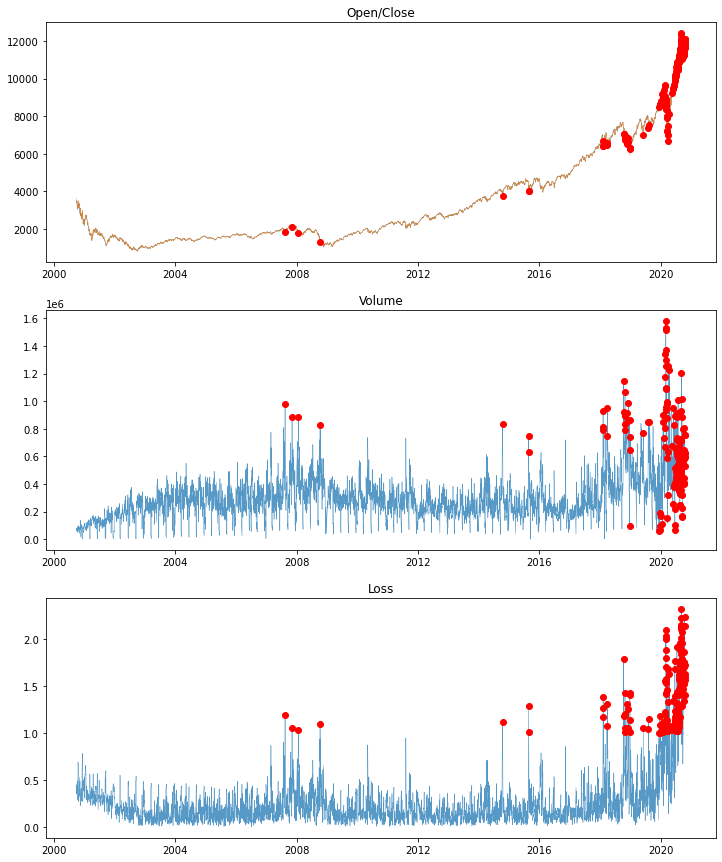

In [42]:
threshold = 1.0
test_df.loc[test_df.Loss > threshold]

fig = plt.figure(figsize=(12, 15))

#가격
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth = 0.5, alpha = 0.75, label = 'Close')
plt.plot(test_df.Date, test_df.Open, linewidth = 0.5, alpha = 0.75, label = 'Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery = [mae_loss > threshold])

#거래량
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth = 0.5, alpha = 0.75, label = 'Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss > threshold])

#오차율
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth = 0.5, alpha = 0.75, label = 'Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery = [mae_loss > threshold])

- 당연하지만, threshold를 낮추면 더 많은 특이치를 찾아낼 수 있음

- 시계열 residual 분석을 통해 신뢰구간 밖의 뎅터를 찾고 이상치 종류와 처리방안을 제시함
- k-means와 DBSCAN을 통해 이상치 데이터를 찾고 이에 대한 해석과 처리방안을 타당하게 제시함
- LSTM 오토인코더 학습을 성공적으로 진행하였으며, 이상치 데이터를 분류하여 이전결과와 비교하였음